# GDS Project Data collection and proccesing
## Hannah Clausen, Tobias Kowalke, Julius Roder

In [1]:
# csv file laden
import geopandas as gpd
import pandas as pd
import seaborn as sns
import numpy as np
import shapely
import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
from splot.libpysal import plot_spatial_weights
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.cluster import DBSCAN
import osmnx as ox
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# load data
df = gpd.read_file("Data/Shapefile/Unfallorte2021_LinRef.shp") #("work/gds/Data/Shapefile/Unfallorte2021_LinRef.shp")

In [3]:
df.head()

OBJECTID            UIDENTSTLA ULAND UREGBEZ UKREIS UGEMEINDE UJAHR UMONAT  \
0         1  01210308125013512021    01       0     54       165  2021     03   
1         2  01210608134013112021    01       0     02       000  2021     06   
2         3  01210610181013902021    01       0     61       007  2021     06   
3         4  01210524161013132021    01       0     53       041  2021     05   
4         5  01210529152013382022    01       0     55       032  2021     05   

  USTUNDE UWOCHENTAG  ... IstFuss IstKrad IstGkfz IstSonstig        LINREFX  \
0      07          2  ...       0       0       0          0  483995.394384   
1      15          3  ...       0       0       0          0  573010.098061   
2      13          5  ...       0       0       0          1  527231.388501   
3      11          2  ...       0       0       0          0  614902.973625   
4      15          7  ...       0       0       0          0  617331.180263   

        LINREFY  XGCSWGS84  YGCSWGS84 USTRZUSTAN  \
0  6.069091e+06   8.751233  54.768787          2   
1  6.020091e+06  10.122558  54.323450          0   
2  5.972658e+06   9.414457  53.901645          0   
3  5.963897e+06  10.745101  53.810913          0   
4  5.996138e+06  10.794357  54.100018          0   

                         geometry  
0  POINT (483995.394 6069091.089)  
1  POINT (573010.098 6020090.876)  
2  POINT (527231.389 5972658.256)  
3  POINT (614902.974 5963896.514)  
4  POINT (617331.180 5996138.283)  

[5 rows x 26 columns]

In [4]:
# filter for bikes
df_bike = df[df["IstRad"] == "1"]

In [5]:
df_bike.size

1864148

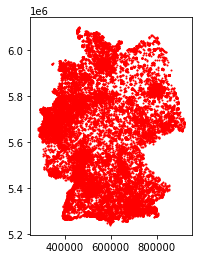

In [6]:
# plot points in df_bike
df_bike.plot(marker="o", color="red", markersize=1);

In [7]:
# Filter for Hamburg
df_bike_hh = df_bike[df_bike["ULAND"] == "02"] # 02 is state id of Hamburg

In [8]:
df_bike_hh.head()

OBJECTID            UIDENTSTLA ULAND UREGBEZ UKREIS UGEMEINDE UJAHR  \
2467      2468  02210923000023355720    02       4     02       403  2021   
2468      2469  02210221000031996600    02       4     07       417  2021   
2487      2488  02210820000025295600    02       2     05       216  2021   
2500      2501  02210701000024207620    02       3     06       318  2021   
2516      2517  02210920000021355480    02       2     03       209  2021   

     UMONAT USTUNDE UWOCHENTAG  ... IstFuss IstKrad IstGkfz IstSonstig  \
2467     09      08          5  ...       0       0       0          0   
2468     02      13          1  ...       0       0       0          0   
2487     08      13          6  ...       0       0       0          0   
2500     07      08          5  ...       0       0       0          0   
2516     09      17          2  ...       0       0       0          0   

            LINREFX       LINREFY  XGCSWGS84  YGCSWGS84 USTRZUSTAN  \
2467  565121.940893  5.938776e+06   9.983936  53.593767          0   
2468  568333.680711  5.935233e+06  10.031679  53.561524          0   
2487  559438.566107  5.935553e+06   9.897464  53.565479          0   
2500  562881.939129  5.941350e+06   9.950617  53.617176          1   
2516  562057.028042  5.935391e+06   9.936962  53.563717          0   

                            geometry  
2467  POINT (565121.941 5938775.540)  
2468  POINT (568333.681 5935233.337)  
2487  POINT (559438.566 5935552.950)  
2500  POINT (562881.939 5941349.834)  
2516  POINT (562057.028 5935390.608)  

[5 rows x 26 columns]

In [9]:
# get districts of hamburg from shapefile
df_districts = gpd.read_file("Data/hh_districts/Stadtteile_Hamburg.shp") #("work/gds/Data/hh_districts/Stadtteile_Hamburg.shp")

In [10]:
df_bike_hh.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
# adjust crs
df_districts = df_districts.to_crs("EPSG:25832")

In [12]:
# Construct variable that indicates whether only bikes were involved in accident
df_bike_hh["IstNurRad"] = df_bike_hh[["IstPKW", "IstGkfz", "IstFuss", "IstKrad", "IstSonstig"]].apply(lambda x: 1 if pd.to_numeric(x).sum() == 0 else 0, axis=1)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


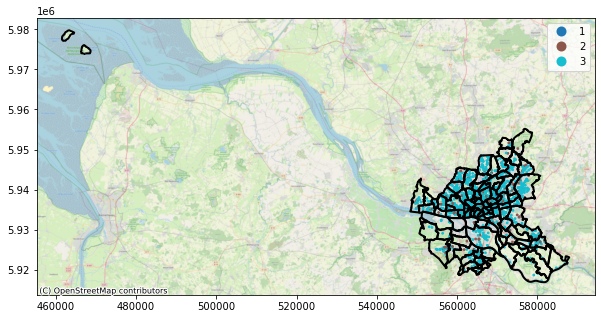

In [13]:
# color legend by 'UKATEGORIE'
fig, ax = plt.subplots(figsize=(10, 10))
df_bike_hh.plot(ax=ax, column="UKATEGORIE", legend=True, markersize=3)
# add districts
df_districts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
# add basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=df_bike_hh.crs.to_string())


In [14]:
# Drop islands (Neuwerk)
df_districts.drop(df_districts[df_districts['stadtteil_'] == 'Neuwerk'].index, inplace = True)

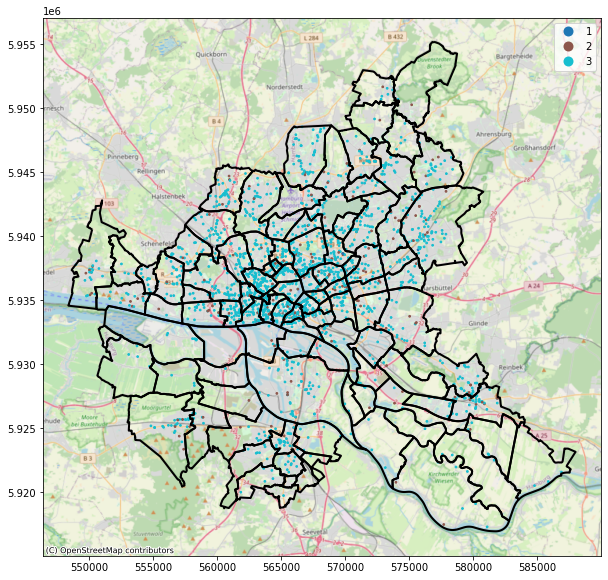

In [15]:
# color legend by 'UKATEGORIE'
fig, ax = plt.subplots(figsize=(10, 10))
df_bike_hh.plot(ax=ax, column="UKATEGORIE", legend=True, markersize=3)
# add districts
df_districts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
# add basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=df_bike_hh.crs.to_string())


# Descriptive analysis

In [16]:
df_bike_hh[['IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstig', 'IstNurRad']].apply(pd.to_numeric).sum()

IstPKW        1285
IstFuss        162
IstKrad         20
IstGkfz         30
IstSonstig     260
IstNurRad      716
dtype: int64

In [17]:
df_bike_hh[['IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstig', 'IstNurRad']].apply(pd.to_numeric).sum()/len(df_bike_hh)

IstPKW        0.523422
IstFuss       0.065988
IstKrad       0.008147
IstGkfz       0.012220
IstSonstig    0.105906
IstNurRad     0.291650
dtype: float64

In [18]:
df_bike_hh[['ULICHTVERH', 'IstRad']].groupby(['ULICHTVERH']).count()

IstRad
ULICHTVERH        
0             1954
1              140
2              361

In [19]:
df_bike_hh[['IstPKW', 'IstRad']].groupby(['IstPKW']).count()

IstRad
IstPKW        
0         1170
1         1285

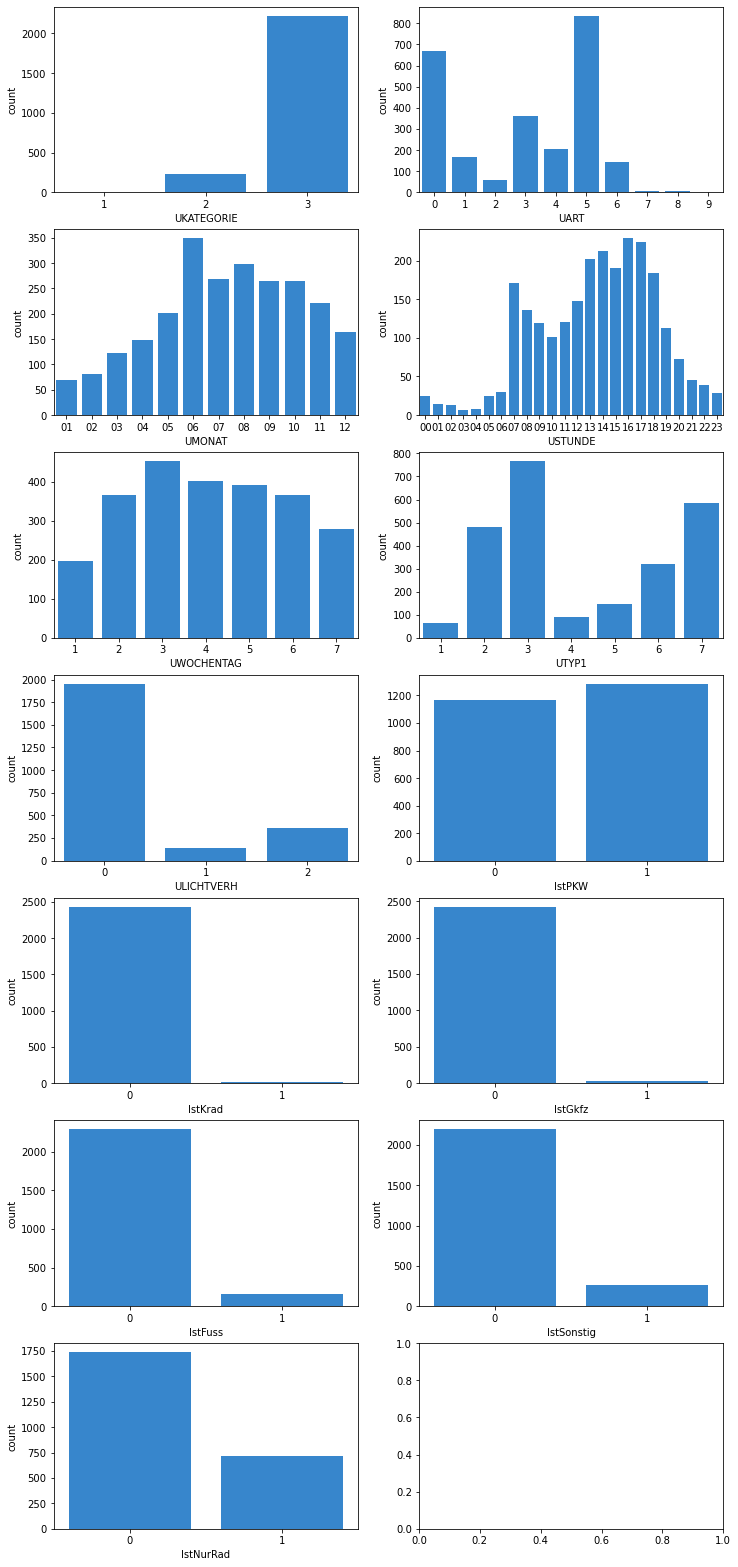

In [20]:
print_cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstFuss", "IstSonstig", "IstNurRad"]

fig, axes = plt.subplots(7,2, figsize=(12,4*7))

ax = axes.ravel()

for i in range(len(print_cols)):

    x = df_bike_hh[print_cols[i]].sort_values()

    sns.countplot(
        x = x
        ,ax = ax[i]
        ,color = '#1E88E5'
    )

plt.show()

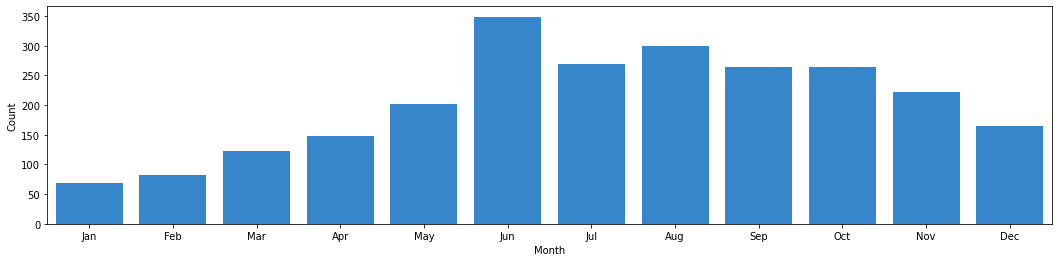

In [21]:
fig, ax = plt.subplots(1,1, figsize=(18,4))

sns.countplot(
    ax = ax
    ,x = df_bike_hh['UMONAT'].sort_values()
    ,color = '#1E88E5'
);

ax.set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'
    , 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ])
ax.set_xlabel('Month')
ax.set_ylabel('Count')

plt.show()

/tmp/ipykernel_5686/540837204.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon'])


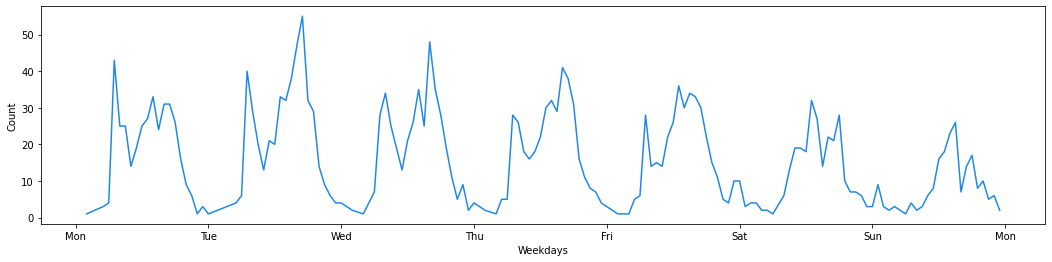

In [22]:
# Time series

df_ts = df_bike_hh[['UWOCHENTAG', 'USTUNDE', 'IstRad']].groupby(['UWOCHENTAG', 'USTUNDE']).count().reset_index()

# Reset 1 to Monday, 7 to Sunday
df_ts['UWOCHENTAG'] = df_ts['UWOCHENTAG'].apply(lambda x: '7' if x == '1' else str(int(x) - 1))
# Convert to datetime
df_ts['datetime'] = df_ts.apply(lambda x: "2021-01-0"+x.UWOCHENTAG+" "+x.USTUNDE+":00:00",axis = 1)

df_ts['datetime'] = df_ts['datetime'].apply(pd.to_datetime)

fig, ax = plt.subplots(1,1, figsize=(18,4))

sns.lineplot(
    ax = ax
    ,x = 'datetime'
    ,y = 'IstRad'
    , data = df_ts
    ,color = '#1E88E5'
);

ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon'])
ax.set_xlabel('Weekdays')
ax.set_ylabel('Count')

plt.show()

## KDE plot

In [23]:
# Get outside borders of Hamburg by joining all polygons
for i, pol in enumerate(df_districts['geometry']):
    if i == 0:
        x = pol
    else:
        x = x.union(pol)

border_hh = gpd.GeoDataFrame({'geometry': x})

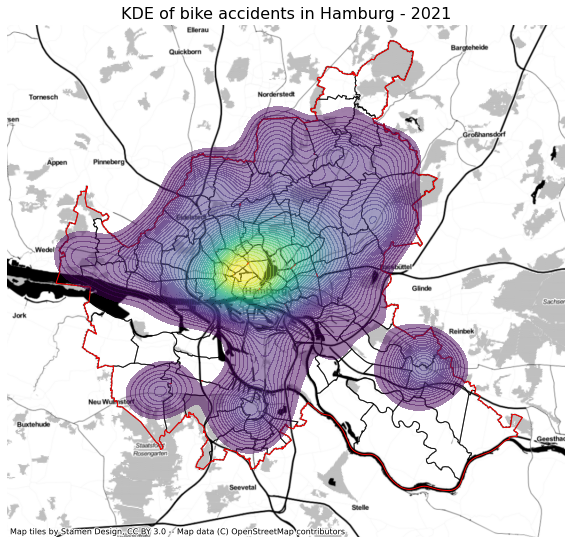

In [24]:
# Plot outer neighborhoods of city
ax = df_districts.plot(facecolor = 'none', edgecolor='black', alpha=0.7, linewidth=1, figsize = (10,10))
# Plot outer boundaries of city
border_hh.plot(facecolor = 'none', edgecolor = 'red', ax = ax)
# Plot KDE plot
sns.kdeplot(x=df_bike_hh['LINREFX'], y=df_bike_hh['LINREFY'], n_levels=50, fill=True, alpha=0.5, cmap='viridis', ax = ax) 
ax.set_axis_off()

cx.add_basemap(ax, crs=df_bike_hh.crs, source=cx.providers.Stamen.Toner) #cx.providers.CartoDB.DarkMatterNoLabels) #providers.OpenStreetMap.Mapnik) 
ax.set_title("KDE of bike accidents in Hamburg - 2021",fontsize = 16)
plt.show() #plt.savefig('KDE_darkmatter.png') #'KDE_stamentoner.png') #'KDE_mapnik.png')

## Correlation matrix - Pearson, Spearman & Cramer's V

In [25]:
# correlation matrix of bike accidents in hamburg
# columns to use
cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "IstNurRad"]

# empty correlation matrix
corr = np.zeros((len(cols), len(cols)))

# convert to int
df_bike_hh_corr = df_bike_hh[cols]
df_bike_hh_corr = df_bike_hh_corr.astype(int)

# Lists to identify scale level of features below
metric = ["UMONAT", "USTUNDE", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig"]
ordinal = ["UKATEGORIE", "ULICHTVERH", "USTRZUSTAN"]
nominal = ["UART", "UWOCHENTAG", "UTYP1"]

# For loop over all columns
for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        # If both columns are metric
        if col1 in metric and col2 in metric:
            # Compute pearsons correlation coefficient
            corr[i,j] = pearsonr(df_bike_hh_corr[col1], df_bike_hh_corr[col2])[0]
        # If both columns are ordinal or one is ordinal and the other metric
        elif col1 in metric + ordinal and col2 in metric + ordinal:
            # Compute spearmans correlation coefficient
            corr[i,j] = spearmanr(df_bike_hh_corr[col1], df_bike_hh_corr[col2])[0]
        # For all other combinations (anything that involves at least one nominal variable)
        else:
            # If possible compute Cramer's V
            try:
                # Create contingency table
                arr = np.array(pd.crosstab(index=df_bike_hh_corr[col1], columns=df_bike_hh_corr[col2]))
                # Compute Cramer's V via chi squared divided by product of number of observations and minimum of rows or columns -1 in contingency table
                # Finally square root
                corr[i,j] = np.sqrt(chi2_contingency(arr)[0]/(df_bike_hh_corr.shape[0] * (min(arr.shape)-1)))
            # If requirements for chi squared are not met, replace value in correlation matrix with nan
            except ValueError:
                corr[i,j] = np.nan

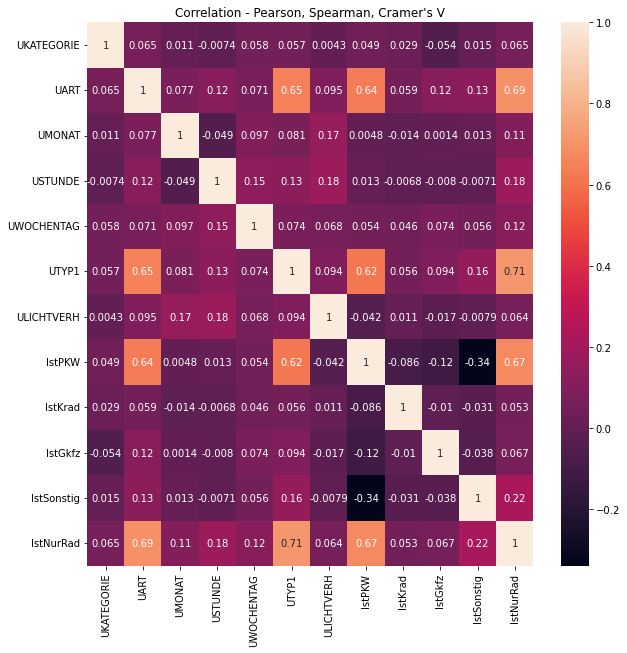

In [26]:
corr_df = pd.DataFrame(corr, columns = cols, index = cols)

# plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_df, annot=True, ax=ax)
plt.title("Correlation - Pearson, Spearman, Cramer's V")
plt.show()

## Spatial Autocorrelation

In [27]:
# detect islands in df_bike_hh geometry
# Create an empty GeoDataFrame to store the islands
islands = gpd.GeoDataFrame(columns=df_districts.columns)

# Loop over each polygon in the GeoDataFrame
for i, row in df_districts.iterrows():
    # Check if the polygon touches any other polygon
    touches = df_districts[df_districts.geometry.touches(row.geometry)]
    
    # If the polygon doesn't touch any other polygon, it's an island
    if touches.empty:
        # Add the island to the GeoDataFrame
        islands = islands.append(row, ignore_index=True)
        # remove the island from the original GeoDataFrame
        df_districts = df_districts.drop(i)
        
islands

Empty GeoDataFrame
Columns: [OBJECTID, bezirk, bezirk_nam, stadtteil_, stadttei_1, stadttei_2, SHAPE_Leng, SHAPE_Area, geometry]
Index: []

In [28]:
df_districts.shape

(103, 9)

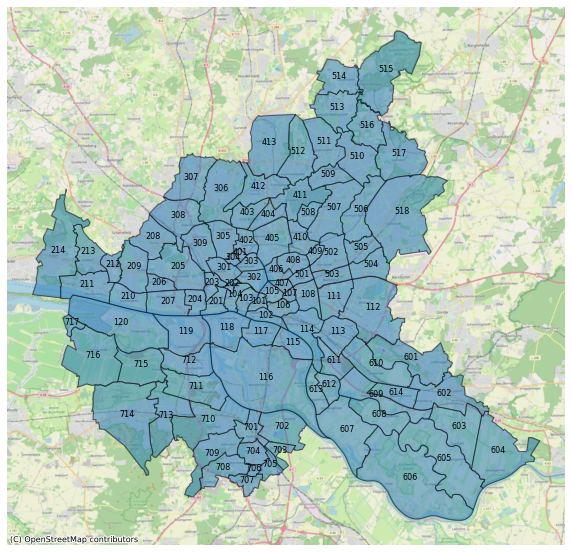

In [29]:
ax = df_districts.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, zoom=12, source=cx.providers.OpenStreetMap.Mapnik, crs=df_bike_hh.crs.to_string())
ax.set_axis_off()
for idx, row in df_districts.iterrows():
    ax.annotate(text=row["stadttei_2"], xy=row['geometry'].centroid.coords[0], 
                horizontalalignment='center', fontsize=8, color='black')


In [30]:
df_districts.head()

OBJECTID bezirk     bezirk_nam        stadtteil_ stadttei_1 stadttei_2  \
0         1      1  Hamburg-Mitte  Hamburg-Altstadt      02101        101   
1         2      1  Hamburg-Mitte         HafenCity      02102        102   
2         3      1  Hamburg-Mitte          Neustadt      02103        103   
3         4      1  Hamburg-Mitte         St. Pauli      02104        104   
4         5      1  Hamburg-Mitte         St. Georg      02105        105   

     SHAPE_Leng    SHAPE_Area  \
0   9028.180532  3.676562e+06   
1  13902.691334  6.860720e+06   
2  11133.923114  6.395226e+06   
3  15968.675123  6.343533e+06   
4   9795.650670  5.155061e+06   

                                            geometry  
0  POLYGON ((566655.103 5933760.301, 566722.625 5...  
1  POLYGON ((566183.919 5932468.981, 566099.304 5...  
2  POLYGON ((565841.224 5934181.092, 565729.797 5...  
3  POLYGON ((563834.747 5933258.107, 563765.973 5...  
4  POLYGON ((567068.406 5933916.007, 567055.305 5...

In [31]:
# add district to df_bike_hh based on geometry
df_bike_hh["bezirk"] = df_bike_hh["geometry"].apply(lambda x: df_districts[df_districts.geometry.contains(x)]["bezirk_nam"].values[0])
df_bike_hh["stadtteil"] = df_bike_hh["geometry"].apply(lambda x: df_districts[df_districts.geometry.contains(x)]["stadtteil_"].values[0])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [32]:
# add id column for districs in df_bike_hh
df_bike_hh["bezirk_id"] = df_bike_hh["bezirk"].apply(lambda x: df_districts[df_districts["bezirk_nam"] == x]["bezirk"].values[0])
df_bike_hh["stadtteil_id"] = df_bike_hh["stadtteil"].apply(lambda x: df_districts[df_districts["stadtteil_"] == x]["stadttei_2"].values[0])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
cat_cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "IstNurRad", "bezirk", "stadtteil"]

In [34]:
# Get dummies
df_dummies = df_bike_hh.copy()
for col in cat_cols:
    dummies = pd.get_dummies(df_dummies[col], prefix=col, prefix_sep='_')
    df_dummies = pd.concat([df_dummies, dummies], axis=1)
    df_dummies = df_dummies.drop(col, axis=1)

In [35]:
# Variable indicating whether accident involved a motorized vehicle
df_dummies['motor'] = np.where((df_dummies['IstKrad_1'] == 1) | (df_dummies['IstPKW_1'] == 1) | (df_dummies['IstGkfz_1'] == 1), 1, 0)

In [36]:
df_grouped_bez = df_dummies.groupby(["bezirk_id"]).sum()
df_grouped_stadt = df_dummies.groupby(["stadtteil_id"]).sum()

In [37]:
df_grouped_stadt.shape # two neighborhoods removed in matching process

(101, 190)

In [38]:
df_districts.head()

OBJECTID bezirk     bezirk_nam        stadtteil_ stadttei_1 stadttei_2  \
0         1      1  Hamburg-Mitte  Hamburg-Altstadt      02101        101   
1         2      1  Hamburg-Mitte         HafenCity      02102        102   
2         3      1  Hamburg-Mitte          Neustadt      02103        103   
3         4      1  Hamburg-Mitte         St. Pauli      02104        104   
4         5      1  Hamburg-Mitte         St. Georg      02105        105   

     SHAPE_Leng    SHAPE_Area  \
0   9028.180532  3.676562e+06   
1  13902.691334  6.860720e+06   
2  11133.923114  6.395226e+06   
3  15968.675123  6.343533e+06   
4   9795.650670  5.155061e+06   

                                            geometry  
0  POLYGON ((566655.103 5933760.301, 566722.625 5...  
1  POLYGON ((566183.919 5932468.981, 566099.304 5...  
2  POLYGON ((565841.224 5934181.092, 565729.797 5...  
3  POLYGON ((563834.747 5933258.107, 563765.973 5...  
4  POLYGON ((567068.406 5933916.007, 567055.305 5...

In [39]:
# group df_districts by bezirk
# group the GeoDataFrame by the 'district_id' column and dissolve the geometries into a single geometry using the 'unary_union' method
bez_geomtries = df_districts.groupby('bezirk')['geometry'].apply(lambda x: x.unary_union)

# convert the resulting series to a GeoDataFrame
dissolved_bez_gdf = gpd.GeoDataFrame(geometry=bez_geomtries)


In [40]:
dissolved_bez_gdf

geometry
bezirk                                                   
1       POLYGON ((566380.311 5925325.069, 566282.956 5...
2       POLYGON ((555651.304 5933510.967, 555337.017 5...
3       POLYGON ((565797.903 5934832.877, 565797.458 5...
4       POLYGON ((564391.545 5937420.714, 564382.192 5...
5       MULTIPOLYGON (((573346.824 5935754.906, 573342...
6       POLYGON ((573715.446 5920276.955, 573693.672 5...
7       POLYGON ((561453.250 5919328.943, 561178.819 5...

In [41]:
# add geomtry from df_districts
df_grouped_bez = df_grouped_bez.merge(dissolved_bez_gdf, left_on="bezirk_id", right_on="bezirk")
df_grouped_stadt = df_grouped_stadt.merge(df_districts, left_on="stadtteil_id", right_on="stadttei_2")

In [42]:
df_grouped_bez["bezirk_id"] = df_grouped_bez.index + 1

Continuing with Stadtteile, since there are only 7 Bezirke

In [43]:
# Get spatial weights matrix
w = weights.Queen.from_dataframe(df_grouped_stadt, idVariable="stadttei_2")

In [44]:
# Row standardize the matrix
w.transform = 'R'

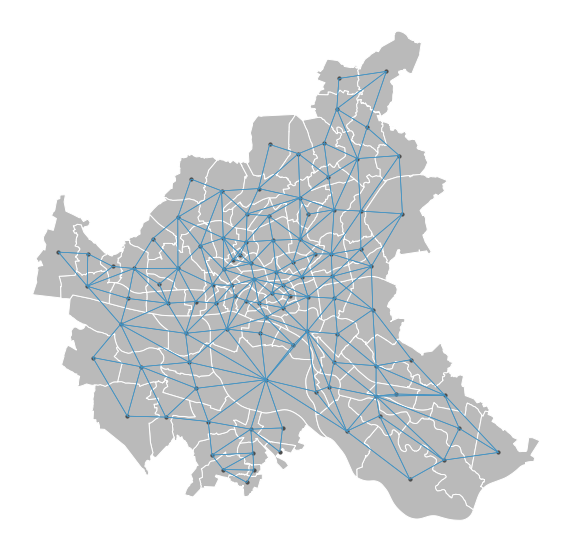

In [45]:
plot_spatial_weights(w, df_grouped_stadt, indexed_on="stadttei_2");

In [46]:
df_grouped_stadt.columns

Index(['OBJECTID_x', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'UKATEGORIE_1', 'UKATEGORIE_2', 'UKATEGORIE_3', 'UART_0', 'UART_1',
       ...
       'motor', 'OBJECTID_y', 'bezirk', 'bezirk_nam', 'stadtteil_',
       'stadttei_1', 'stadttei_2', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object', length=199)

### Moran's I

In [47]:
df_grouped_stadt["count"] = df_grouped_stadt["IstPKW_1"] + df_grouped_stadt["IstPKW_0"]

In [48]:
df_grouped_stadt['w_count'] = weights.lag_spatial(w, df_grouped_stadt['count']) # we pass the weights object and the column with values to base the spatial lag on
df_grouped_stadt['count_std'] = (df_grouped_stadt['count'] - df_grouped_stadt['count'].mean()) / df_grouped_stadt['count'].std()
df_grouped_stadt['w_count_std'] = weights.lag_spatial(w, df_grouped_stadt['count_std'])

In [49]:
# Moran's I
mi = esda.Moran(df_grouped_stadt['w_count_std'], w)
print(mi.I)
print(mi.p_sim)

0.7312822383133449
0.001


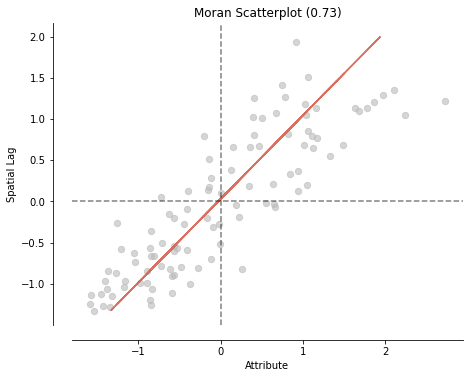

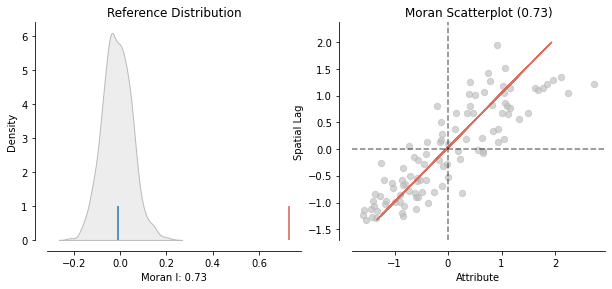

In [50]:
moran_scatterplot(mi);
plot_moran(mi);

### LISA

In [51]:
df_grouped_stadt.head()

OBJECTID_x       LINREFX       LINREFY   XGCSWGS84    YGCSWGS84  \
0     6170234  3.282793e+07  3.441709e+08  579.777817  3105.932639   
1     2522647  1.359653e+07  1.423888e+08  240.091828  1284.972071   
2     5503962  3.220508e+07  3.382443e+08  568.925221  3052.456044   
3     6849751  3.440405e+07  3.619926e+08  607.931168  3266.776836   
4     7878806  3.230933e+07  3.382705e+08  570.504165  3052.678042   

   UKATEGORIE_1  UKATEGORIE_2  UKATEGORIE_3  UART_0  UART_1  ...  \
0             0             8            50      14       0  ...   
1             0             0            24       6       2  ...   
2             0             1            56      24       2  ...   
3             0             5            56      19       1  ...   
4             0             3            54      18       5  ...   

         stadtteil_  stadttei_1  stadttei_2    SHAPE_Leng    SHAPE_Area  \
0  Hamburg-Altstadt       02101         101   9028.180532  3.676562e+06   
1         HafenCity       02102         102  13902.691334  6.860720e+06   
2          Neustadt       02103         103  11133.923114  6.395226e+06   
3         St. Pauli       02104         104  15968.675123  6.343533e+06   
4         St. Georg       02105         105   9795.650670  5.155061e+06   

                                            geometry  count    w_count  \
0  POLYGON ((566655.103 5933760.301, 566722.625 5...     58  40.800000   
1  POLYGON ((566183.919 5932468.981, 566099.304 5...     24  24.000000   
2  POLYGON ((565841.224 5934181.092, 565729.797 5...     57  37.800000   
3  POLYGON ((563834.747 5933258.107, 563765.973 5...     61  37.400000   
4  POLYGON ((567068.406 5933916.007, 567055.305 5...     57  33.166667   

   count_std  w_count_std  
0   1.482114     0.725508  
1  -0.013501    -0.013501  
2   1.438125     0.593542  
3   1.614080     0.575947  
4   1.438125     0.389728  

[5 rows x 203 columns]

In [52]:
def plot_lisa(df, column, w, p=0.05):
    df_copy = df.copy()
    w_col = "w_" + column
    std_col = column + "_std"
    w_std_col = "w_" + column + "_std"
    df[w_col] = weights.lag_spatial(w, df[column])
    df[std_col] = (df[column] - df[column].mean()) / df[column].std()
    df[w_std_col] = weights.lag_spatial(w, df[std_col])
    lisa = esda.Moran_Local(df[w_std_col], w)
    # Break observations into significant or not
    df['significant'] = lisa.p_sim < p
    # Store the quadrant they belong to
    df['quadrant'] = lisa.q
    # calculate morans I 
    mi = esda.Moran(df[w_std_col], w)
    print(mi.I, mi.p_sim)
    plot_local_autocorrelation(lisa, df, w_std_col);

In [53]:
df_grouped_stadt['IstGkfz_1_ratio'] = df_grouped_stadt['IstGkfz_1'] / df_grouped_stadt['count']

0.2958470008686855 0.001


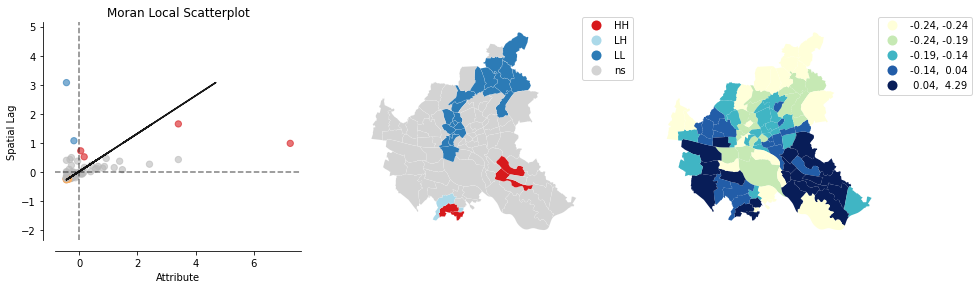

In [54]:
plot_lisa(df_grouped_stadt, "IstGkfz_1_ratio", w, p=0.05)

0.7312822383133449 0.001


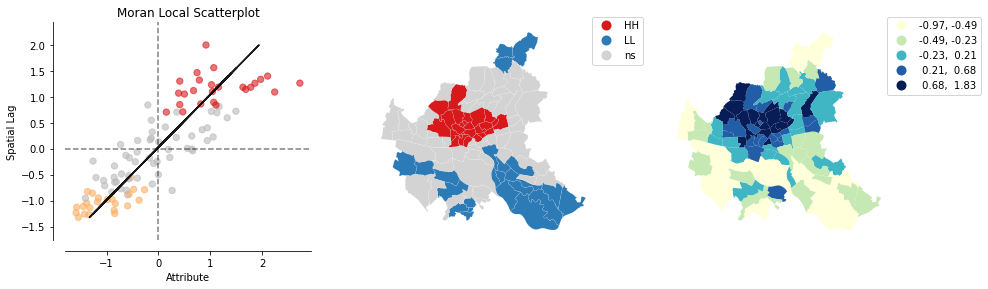

In [55]:
plot_lisa(df_grouped_stadt, "count", w, p=0.05)

0.7312822383133449 0.001


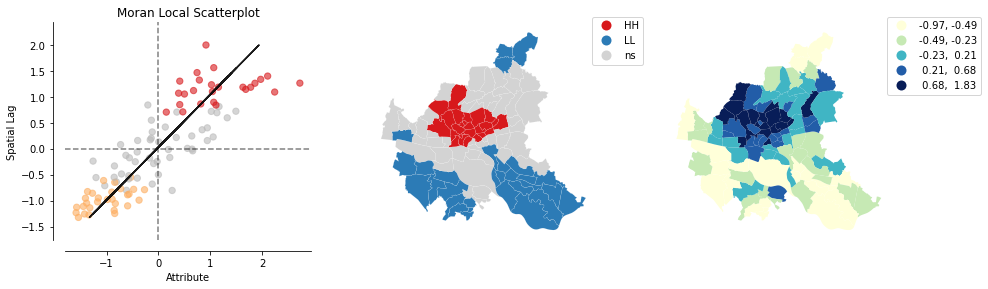

In [56]:
plot_lisa(df_grouped_stadt, "count", w, p=0.05)

In [57]:
# Share of accidents involving a motorized vehicle
df_grouped_stadt['motor_ratio'] = df_grouped_stadt['motor'] / df_grouped_stadt['count']

0.37545811463450396 0.001


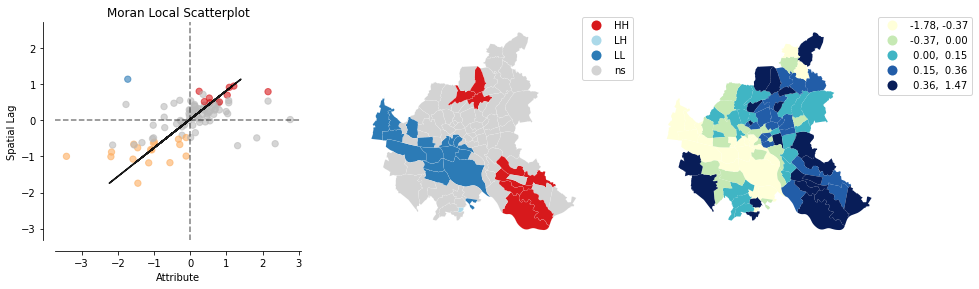

In [58]:
plot_lisa(df_grouped_stadt, "motor_ratio", w, p=0.05)

In [59]:
# Weekdays vs. weekend
df_grouped_stadt["weekend"] = df_grouped_stadt["UWOCHENTAG_7"] + df_grouped_stadt["UWOCHENTAG_1"]
df_grouped_stadt["weekday"] = df_grouped_stadt["UWOCHENTAG_6"] + df_grouped_stadt["UWOCHENTAG_2"] + df_grouped_stadt["UWOCHENTAG_3"] + df_grouped_stadt["UWOCHENTAG_4"] + df_grouped_stadt["UWOCHENTAG_5"]

In [60]:
df_grouped_stadt['weekend_ratio'] = df_grouped_stadt['weekend'] / df_grouped_stadt['count']
df_grouped_stadt['weekday_ratio'] = df_grouped_stadt['weekday'] / df_grouped_stadt['count']

In [61]:
# calculate area of each stadtteil in square meters
df_grouped_stadt["SHAPE_Area"] = df_grouped_stadt["geometry"].area
# area in sq km
df_grouped_stadt["SHAPE_Area"] = df_grouped_stadt["geometry"].area / 1000000
# calcluate count per square meter
df_grouped_stadt["count_per_sqkm"] = df_grouped_stadt["count"] / df_grouped_stadt["SHAPE_Area"]

In [62]:
# print value range for shapre_area and neighboorhod name
df_grouped_stadt[["SHAPE_Area", "stadtteil_"]].sort_values(by="SHAPE_Area")


SHAPE_Area          stadtteil_
19    0.548077        Sternschanze
41    0.565130        Hoheluft-Ost
35    0.719088       Hoheluft-West
90    0.792942           Langenbek
6     0.821506           Borgfelde
..         ...                 ...
17   19.628036        Finkenwerder
98   22.507116  Neugraben-Fischbek
71   26.548566           Rahlstedt
77   32.286891         Kirchwerder
13   35.362574        Wilhelmsburg

[101 rows x 2 columns]

0.867945618324733 0.001


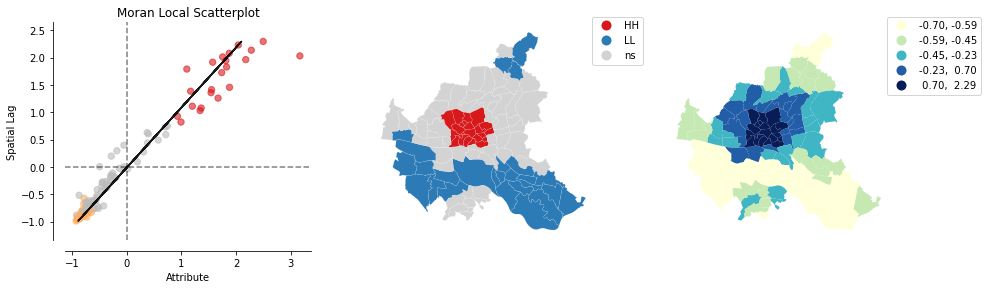

In [63]:
plot_lisa(df_grouped_stadt, "count_per_sqkm", w, p=0.05)

In [64]:
columns = ["count", "IstPKW_1", "IstPKW_0", "weekend", "weekday", "IstNurRad_1", "IstNurRad_0", "motor"]
for column in columns:
    df_grouped_stadt[column + "_per_sqkm"] = df_grouped_stadt[column] / df_grouped_stadt["SHAPE_Area"]

0.8522736468500536 0.001


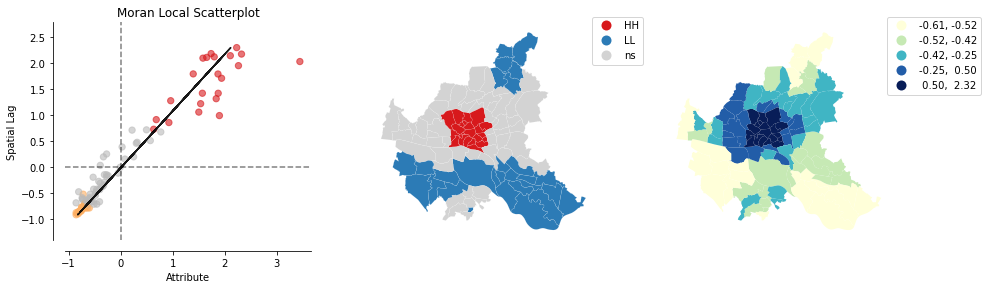

In [65]:
plot_lisa(df_grouped_stadt, "weekend_per_sqkm", w, p=0.05)

0.8668469915503217 0.001


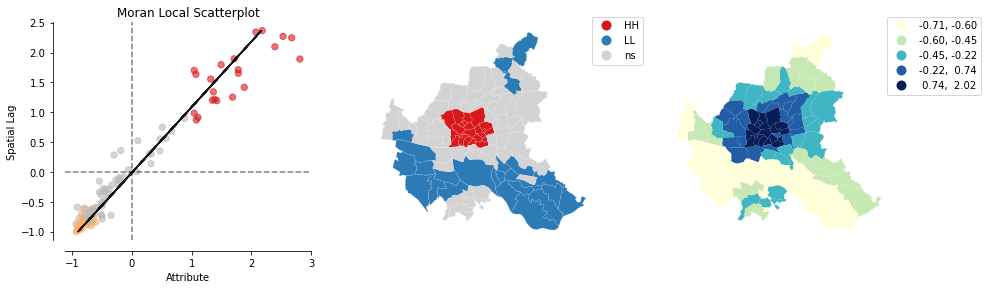

In [66]:
plot_lisa(df_grouped_stadt, "motor_per_sqkm", w, p=0.05)

0.8533398048585765 0.001


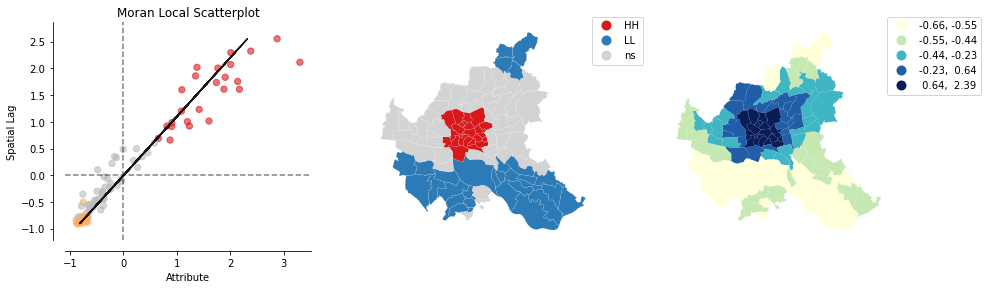

In [67]:
plot_lisa(df_grouped_stadt, "IstNurRad_1_per_sqkm", w, p=0.05)

## Point Pattern Analysis

0.867945618324733 0.001


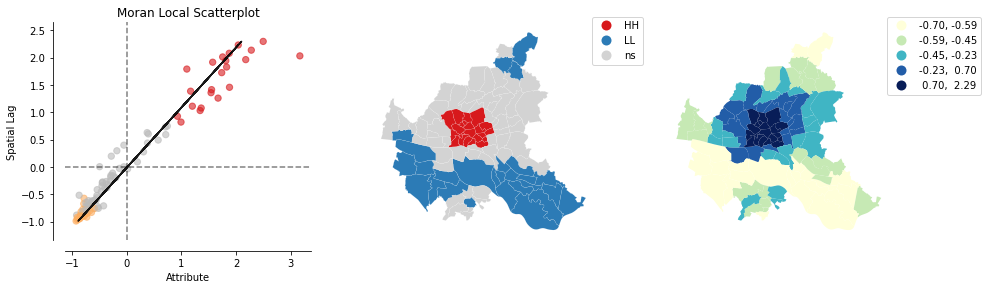

In [68]:
# Basis for the analysis
plot_lisa(df_grouped_stadt, "count_per_sqkm", w, p=0.05)

In [69]:
# Construct subset based on significant HH neighborhoods
bike_copy = df_grouped_stadt.copy()
bike_copy['w_countpsqm'] = weights.lag_spatial(w, bike_copy["count_per_sqkm"])
bike_copy['std_countpsqm'] = (bike_copy["count_per_sqkm"] - bike_copy["count_per_sqkm"].mean()) / bike_copy["count_per_sqkm"].std()
bike_copy['w_std_countpsqm'] = weights.lag_spatial(w, bike_copy['std_countpsqm'])
lisa = esda.Moran_Local(bike_copy['w_std_countpsqm'], w)
bike_copy['lisa'] = lisa.Is
bike_copy['lisa_p'] = lisa.p_sim
bike_copy['lisa_q'] = lisa.q # 1 HH, 2 LH, 3 LL, 4 HL

In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [71]:
sig_lisas = bike_copy[bike_copy['lisa_p'] < 0.05]

In [72]:
sig_lisas_hh = sig_lisas[sig_lisas['lisa_q'] == 1]

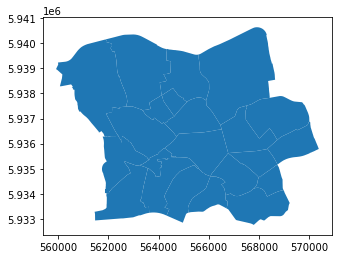

In [73]:
sig_lisas_hh.plot();

In [74]:
sig_lisas_hh.shape

(22, 243)

In [75]:
df_bike_hh.columns

Index(['OBJECTID', 'UIDENTSTLA', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE',
       'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART',
       'UTYP1', 'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad',
       'IstGkfz', 'IstSonstig', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'USTRZUSTAN', 'geometry', 'IstNurRad', 'bezirk', 'stadtteil',
       'bezirk_id', 'stadtteil_id'],
      dtype='object')

In [76]:
# get all data on accidents
center = df_bike_hh[df_bike_hh['stadtteil'].isin(sig_lisas_hh['stadtteil_'])]

In [77]:
df_districts.columns

Index(['OBJECTID', 'bezirk', 'bezirk_nam', 'stadtteil_', 'stadttei_1',
       'stadttei_2', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [78]:
# get respective neighborhood geometry
df_district_center = df_districts[df_districts['stadtteil_'].isin(sig_lisas_hh['stadtteil_'])]

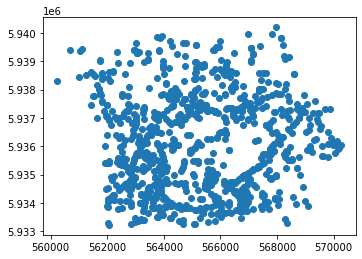

In [79]:
center.plot();

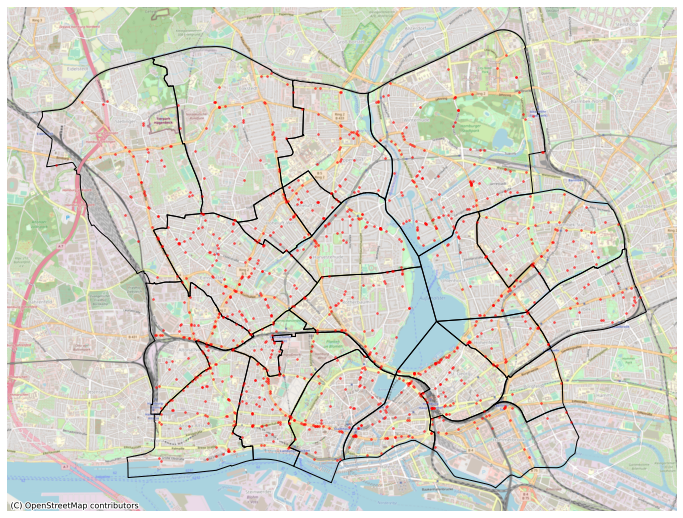

In [80]:
# Point map of accidents
fig, ax = plt.subplots(1, figsize=(12,12)) 

df_district_center.plot(ax=ax, facecolor='none', edgecolor='black')
center.plot(ax=ax, markersize=3, c="red", alpha=0.5,) 

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=center.crs,
    source= cx.providers.OpenStreetMap.Mapnik # cx.providers.CartoDB.DarkMatter # providers.Stamen.Toner
)

plt.savefig('center_dotmap.png')

In [81]:
# Construct (categorical) variable on whether accident involved motorized vehicle
center['motor'] = np.where((center['IstKrad'] == '1') | (center['IstPKW'] == '1') | (center['IstGkfz'] == '1'), 'No motorized vehicle', 'Motorized vehicle')

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


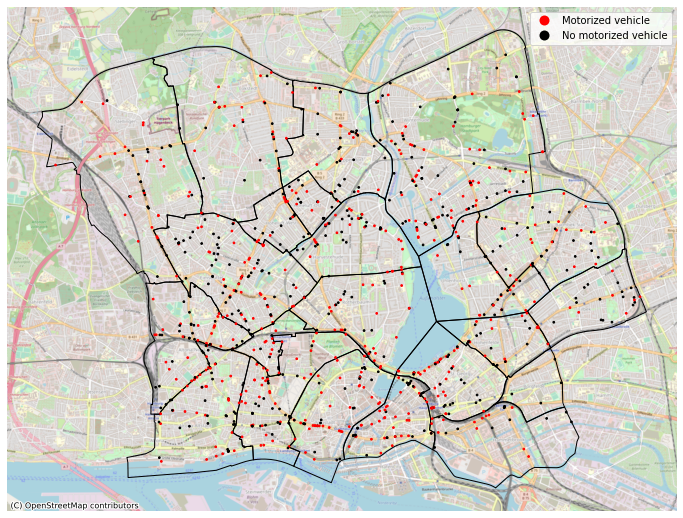

In [82]:
# Color accidents based on whether they involved a motorized vehicle
color_map = ListedColormap(["red", "black"])

fig, ax = plt.subplots(1, figsize=(12,12)) # visualize with two different colors --> car involved vs no car involved

df_district_center.plot(ax=ax, facecolor='none', edgecolor='black')
center.plot(column = 'motor', ax=ax, cmap = color_map, legend = True, categorical = True, markersize=3, alpha=1) #xkcd:bright yellow

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=center.crs,
    source= cx.providers.OpenStreetMap.Mapnik # cx.providers.CartoDB.DarkMatter # providers.Stamen.Toner
)

plt.savefig('center_dotmapMotor.png')

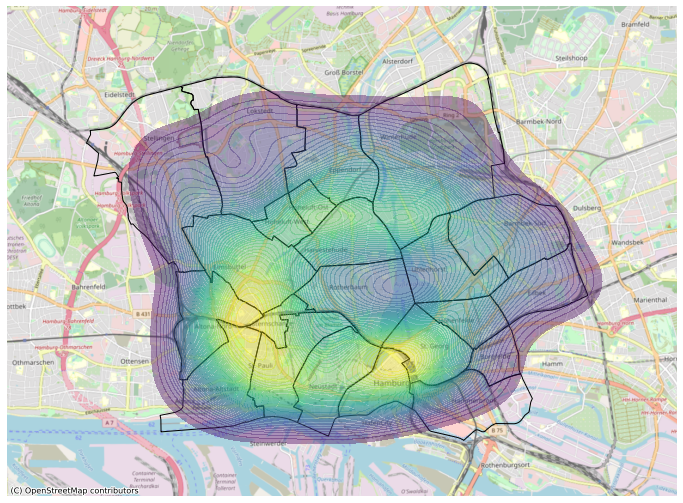

In [83]:
# KDE plot of center
fig, ax = plt.subplots(1, figsize=(12,12))

df_district_center.plot(ax=ax, facecolor='none', edgecolor='black')
sns.kdeplot(
    x=center['LINREFX'], 
    y=center['LINREFY'], 
    n_levels=50, 
    fill=True,
    alpha=0.4,
    cmap="viridis", 
    ax = ax
)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=center.crs,
    source= cx.providers.OpenStreetMap.Mapnik#providers.Stamen.Toner # cx.providers.CartoDB.DarkMatter
)

plt.savefig('center_kde.png')

In [84]:
# Get street network based on central location Rothenbaumchaussee 32 and 7km radius
G = ox.graph_from_address(
    address="32 Rothenbaumchaussee, Hamburg",
    dist=7000,
    dist_type="network",
    network_type="all",
)

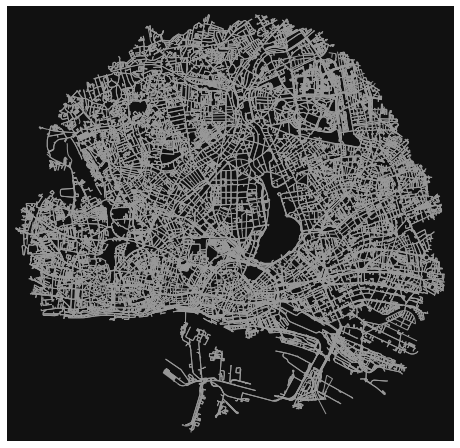

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [85]:
ox.plot_graph(G, node_size = 0)

In [86]:
# Get gdfs on nodes and edges
center_nodes, center_edges = ox.utils_graph.graph_to_gdfs(G, 
                                      nodes = True, 
                                      edges = True, 
                                      node_geometry = True,
                                      fill_edge_geometry = True)

In [87]:
center_edges = center_edges.to_crs(center.crs)
center_edges = center_edges.rename_geometry('geometry_street')

In [88]:
G.graph['crs']

'epsg:4326'

In [89]:
# Project crs
G_crs = ox.projection.project_graph(G, to_crs=center.crs)

In [90]:
G_crs.graph['crs']

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [91]:
# Get nearest edge to each accident and merge data together
cols = center_edges.columns.to_list()
cols.extend(center.columns.to_list())

df_nearest_edges = pd.DataFrame(columns = cols)
dist = []

count = 0

for i in range(len(center)):
    edge = ox.distance.nearest_edges(G_crs, center['LINREFX'].iloc[i], center['LINREFY'].iloc[i], return_dist = True)
    df_nearest_edges.loc[i,:] = pd.concat([center_edges.loc[edge[0]], center.iloc[i]])
    dist.append(edge[1])
    count += 1
    if count%10 == 0:
        print(count)
                                           
        
# df_nearest_edges.to_csv('matchednearest_edge.csv')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020


In [92]:
df_nearest_edges['highway'] = [tuple(x) if type(x) == list else x for x in df_nearest_edges['highway']]
df_nearest_edges['name'] = [tuple(x) if type(x) == list else x for x in df_nearest_edges['name']]

In [93]:
pd.crosstab(df_nearest_edges['highway'], df_nearest_edges['motor'])

motor                         Motorized vehicle  No motorized vehicle
highway                                                              
(pedestrian, residential)                     2                     1
(residential, living_street)                  0                     2
(secondary_link, cycleway)                    1                     1
(steps, footway)                              1                     3
corridor                                      1                     1
cycleway                                      5                     9
footway                                      27                    42
path                                          7                    13
pedestrian                                    2                     0
primary                                     101                    82
primary_link                                  0                     1
residential                                 140                   168
secondary                                    72                    69
secondary_link                                1                     1
service                                      20                    14
tertiary                                     85                   116
tertiary_link                                 1                     1
unclassified                                 16                    14

In [94]:
df_nearest_edges['highway'].value_counts()

residential                     308
tertiary                        201
primary                         183
secondary                       141
footway                          69
service                          34
unclassified                     30
path                             20
cycleway                         14
(steps, footway)                  4
(pedestrian, residential)         3
secondary_link                    2
tertiary_link                     2
(residential, living_street)      2
(secondary_link, cycleway)        2
pedestrian                        2
corridor                          2
primary_link                      1
Name: highway, dtype: int64

In [95]:
center_edges['highway'].value_counts()

footway                                       54717
service                                       20289
residential                                   18430
path                                           6927
tertiary                                       5269
secondary                                      4820
[steps, footway]                               3878
primary                                        3586
unclassified                                   3005
cycleway                                       1342
[service, footway]                              682
steps                                           676
pedestrian                                      640
track                                           640
living_street                                   498
[residential, footway]                          240
secondary_link                                  214
[footway, path]                                 183
tertiary_link                                   131
primary_link

In [96]:
df_nearest_edges['name'].value_counts() # filter for more than 10

Kieler Straße                                           19
Max-Brauer-Allee                                        18
Eppendorfer Weg                                         16
Harvestehuder Weg                                       15
An der Alster                                           14
Stresemannstraße                                        14
Barmbeker Straße                                        11
Sierichstraße                                           10
Ludwig-Erhard-Straße                                    10
Bellevue                                                 8
Weidenallee                                              7
Bundesstraße                                             7
Falkenried                                               7
Kennedybrücke                                            7
Osterstraße                                              6
Reeperbahn                                               6
Hamburger Straße                                        

In [97]:
pd.crosstab(df_nearest_edges['name'], df_nearest_edges['motor'])

motor                                               Motorized vehicle  \
name                                                                    
(Budapester Straße, Neuer Pferdemarkt)                              0   
(Fehlandtstraße, Große Theaterstraße)                               0   
(Große Bahnstraße, Waidmannstraße)                                  1   
(Gänsemarkt, Jungfernstieg)                                         1   
(St. Pauli Fischmarkt, St. Pauli Hafenstraße)                       1   
(Vorsetzen, Johannisbollwerk)                                       1   
(Willy-Brandt-Straße, Deichtortunnel, Amsinckst...                  0   
Abendrothsweg                                                       0   
Abteistraße                                                         1   
Adenauerallee                                                       0   
Admiralitätstraße                                                   1   
Adolph-Schönfelder-Straße                                           2   
Adolphsplatz                                                        1   
Agnesstraße                                                         0   
Ahornallee                                                          0   
Alsenplatz                                                          2   
Alsenstraße                                                         4   
Alsterchaussee                                                      3   
Alsterdorfer Straße                                                 1   
Alsterglacis                                                        1   
Alsterpassage                                                       1   
Alsterterrasse                                                      1   
Alsterufer                                                          1   
Alte Rabenstraße                                                    1   
Alte Wöhr                                                           2   
Alter Fischmarkt                                                    1   
Alter Wall                                                          1   
Altmannbrücke                                                       0   
Altonaer Straße                                                     1   
Am Brunnenhof                                                       1   
Am Langenzug                                                        0   
An der Alster                                                      11   
An der Kunsthalle                                                   0   
Anckelmannsplatz                                                    1   
Armgartstraße                                                       1   
Auf dem Sande                                                       0   
Augustenburger Straße                                               1   
Ausschläger Weg                                                     0   
Averhoffstraße                                                      1   
Ballindamm                                                          3   
Barcastraße                                                         1   
Barmbeker Straße                                                    7   
Basselweg                                                           3   
Baumeisterstraße                                                    1   
Beethovenstraße                                                     0   
Behnstraße                                                          0   
Bei den Mühren                                                      1   
Bei den St. Pauli-Landungsbrücken                                   0   
Bei der Petrikirche                                                 1   
Beim Grünen Jäger                                                   1   
Beim Schlump                                                        3   
Beim Trichter                                                       0   
Bellevue                                                  

In [98]:
# Get streets with more than 10 accidents
street_names = df_nearest_edges['name'].value_counts()[df_nearest_edges['name'].value_counts() >= 10].index
ind = [i for i, acc in enumerate(df_nearest_edges['name']) if acc in street_names]
df_nearest_10 = df_nearest_edges.iloc[ind]

In [99]:
df_nearest_10.name.value_counts()

Kieler Straße           19
Max-Brauer-Allee        18
Eppendorfer Weg         16
Harvestehuder Weg       15
Stresemannstraße        14
An der Alster           14
Barmbeker Straße        11
Ludwig-Erhard-Straße    10
Sierichstraße           10
Name: name, dtype: int64

In [100]:
pd.crosstab(df_nearest_10['name'], df_nearest_10['motor'])

motor                 Motorized vehicle  No motorized vehicle
name                                                         
An der Alster                        11                     3
Barmbeker Straße                      7                     4
Eppendorfer Weg                       7                     9
Harvestehuder Weg                     9                     6
Kieler Straße                         5                    14
Ludwig-Erhard-Straße                  9                     1
Max-Brauer-Allee                     12                     6
Sierichstraße                         4                     6
Stresemannstraße                      7                     7

In [101]:
df_nearest_edges['high_count'] = 0
df_nearest_edges['high_count'].iloc[ind] = 1

/tmp/ipykernel_5686/1187755223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nearest_edges['high_count'].iloc[ind] = 1


In [102]:
df_nearest_edges['high_count'].mean()

0.12450980392156863

In [103]:
## Add edge attribute
# in order to loop over, has to be converted into tuple
center_edges['name'] = [tuple(x) if type(x) == list else x for x in center_edges['name']]

In [104]:
center_edges = center_edges.to_crs('EPSG:4326')
center_edges = center_edges.rename_geometry('geometry')

ind = [i for i, acc in enumerate(center_edges['name']) if acc in street_names]

center_edges['high_count'] = 0
center_edges['high_count'].iloc[ind] = 1

/tmp/ipykernel_5686/1901174752.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_edges['high_count'].iloc[ind] = 1


In [105]:
# convert back into list
center_edges['name'] = [list(x) if type(x) == tuple else x for x in center_edges['name']]

In [106]:
# Construct graph with new attribute from gdfs on nodes and edges
G_newatt = ox.graph_from_gdfs(center_nodes, center_edges)

In [107]:
center_edges['high_count'].value_counts()

0    126587
1      1025
Name: high_count, dtype: int64

In [108]:
# Check whether new attribute is in graph attributes
for u, v, k, d in G_newatt.edges(keys=True, data=True):
    print(d)
    break

{'osmid': 4928829, 'oneway': True, 'lanes': '2', 'highway': 'trunk_link', 'length': 24.463, 'geometry': <shapely.geometry.linestring.LineString object at 0x7fa843490c70>, 'high_count': 0}


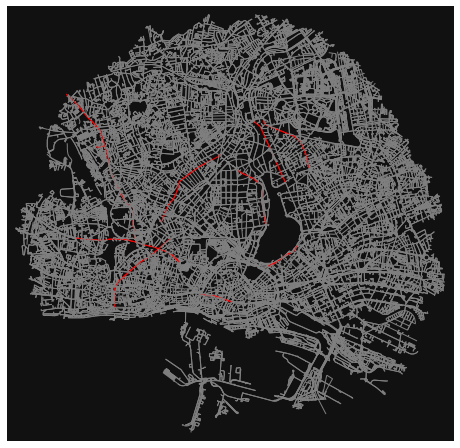

In [109]:
# Plot graph with marked 'high count' streets 
color_map = ListedColormap(["gray", "red"])
edge_types = df_nearest_edges['high_count'].value_counts()
color_list = ox.plot.get_colors(n=len(edge_types), cmap=color_map)
color_mapper = pd.Series(color_list, index=edge_types.index).to_dict()

# get the color for each edge based on its highway type
ec = [color_mapper[d['high_count']] for u, v, k, d in G_newatt.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_newatt, edge_color=ec, node_size = 0)
plt.show()

In [110]:
# pd.DataFrame(center_edges).to_csv('center_edges.csv')
# pd.DataFrame(center_nodes).to_csv('center_nodes.csv')